In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Input Data

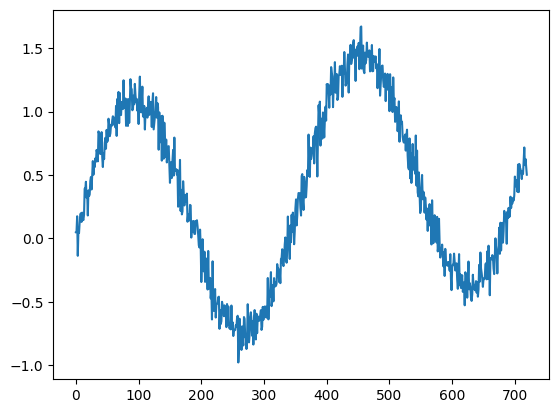

In [9]:
input_size = 720

rawWave = np.sin(np.radians(np.arange(0,input_size,dtype=float)))
noise = np.random.normal(0,1e-1,input_size)
drift = np.arange(0., float(input_size)/1000, 0.001, dtype=float)

signal = rawWave + noise + drift
plt.plot(np.arange(0,input_size),input)
plt.show()

input_data = np.zeros((input_size,input_size))
np.fill_diagonal(input_data, 1)

# Model

In [11]:
# Modified from https://github.com/KTAswathi/IPB_2023/blob/main/IPB_lab3_BPTT.ipynb

import numpy as np
from numpy.random import randn

class RNN:
    # A Vanilla Recurrent Neural Network.

    def __init__(self, input_size, output_size, hidden_size=64):
        # Weights
        self.Whh = randn(hidden_size, hidden_size) / 1000
        self.Wxh = randn(hidden_size, input_size) / 1000
        self.Why = randn(output_size, hidden_size) / 1000
        self.Wfeedback = randn(hidden_size, input_size) / 1000
        
        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        h = np.zeros((self.Whh.shape[0], 1))
        self.last_inputs = inputs
        self.last_hs = { 0: h }
        # Perform each step of the RNN
        for i, x in enumerate(inputs):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            self.last_hs[i + 1] = h
        
        # Compute the output
        y = self.Why @ h + self.by
        return y, h
    
    # def PC(self, y, h, y_true, pred_weight):
    #     output_error = y_true - y
    #     pred = h + pred_weight * self.Wfeedback * output_error # Might need to do something to dot these
    #     pred_error = pred - h

        
     
